In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
%matplotlib inline
import seaborn.apionly as sns
import pickle

# ignore pandas warnings
import warnings
warnings.simplefilter('ignore')

import time
start = time.time()

In [2]:
# continue the previous notebooks, loading the data: 

with open('data_train_test.p', 'rb') as handle:
    data_train_test = pickle.load(handle)
    
x_train, y_train = data_train_test['train']
x_test, y_test = data_train_test['test']

sorted_feat_importances = pd.read_excel('feature_importances.xlsx')

In [3]:
# select features up to gagedays (included)
feat_subset = sorted_feat_importances.iloc[:20].index.tolist() 

x_train = x_train[:,feat_subset]
x_test = x_test[:,feat_subset]

In [4]:
# xgboost
from xgboost import XGBRegressor
xgb = XGBRegressor(max_depth=7,learning_rate=0.05,n_estimators=500,subsample=0.9)

In [5]:
xgb.fit(x_train, y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.05, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=500, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.9)

In [6]:
y_pred = xgb.predict(x_test)

In [7]:
# transform back from log scale
w_true = np.exp(y_test) - 1
w_pred = np.exp(y_pred) - 1

In [8]:
pct_error = np.abs(w_true-w_pred)/w_true*100
mean_pct_error = pct_error.mean()

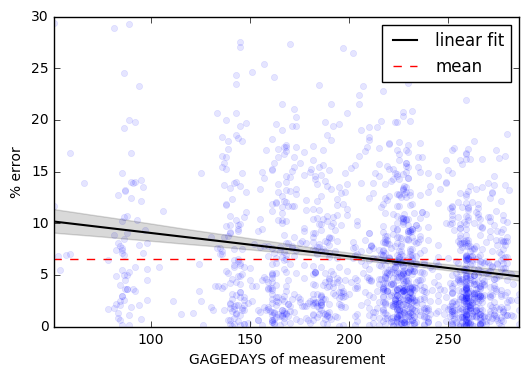

In [9]:
t = x_test[:,19]
sns.regplot(x=t,y=pct_error, scatter_kws={'alpha':0.1},fit_reg=True, line_kws={'color':'k','label':'linear fit'})
plt.ylim(0,50)
plt.xlim(t.min(),t.max())
plt.xlabel('GAGEDAYS of measurement')
plt.ylabel('% error')
plt.hlines(mean_pct_error,xmin=0,xmax=350,colors='r',linestyles='dashed',label='mean')
plt.ylim(0,30)
plt.legend();

In [10]:
week_bins = np.digitize(x=t, bins=np.arange(0,t.max(),14))

pct_error_binned_df = pd.DataFrame(np.concatenate((pct_error.reshape(-1,1),week_bins.reshape(-1,1)),axis=1), 
                                columns=['y_test','bin'])

In [11]:
pct_error_binned_df = pct_error_binned_df.groupby('bin').agg([np.mean,np.std,'count'])
pct_error_binned_df.columns = pct_error_binned_df.columns.droplevel()
pct_error_binned_df

,mean,std,count
bin,,,
4.0,13.323760,11.036687,4
5.0,11.151914,4.968958,4
6.0,7.095170,7.802204,12
7.0,8.754033,6.690418,55
8.0,10.789069,14.563116,8
9.0,4.895711,5.217138,6
10.0,9.546378,6.149976,33
11.0,7.554714,7.363172,87
12.0,6.685569,6.057503,109


In [12]:
times_sigma = 1
pct_error_binned_df['upper'] = pct_error_binned_df['mean'] + times_sigma*pct_error_binned_df['std']
pct_error_binned_df['lower'] = pct_error_binned_df['mean'] - times_sigma*pct_error_binned_df['std']
pct_error_binned_df['lower'] *= pct_error_binned_df['lower'] > 0

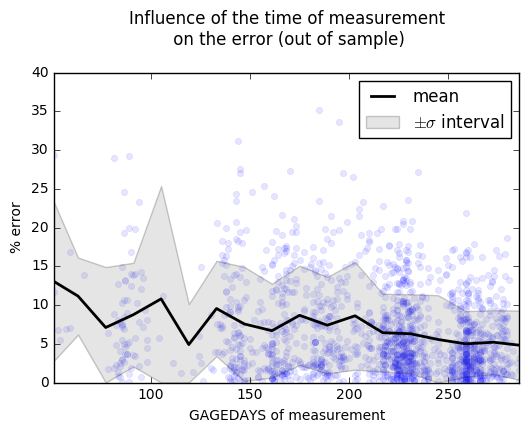

In [13]:
reescaled_x = pct_error_binned_df.index*14-7
ax = sns.regplot(x=t,y=pct_error, scatter_kws={'alpha':0.1},fit_reg=False)
ax.plot(reescaled_x,pct_error_binned_df['mean'],label='mean',lw=2,color='k')
ax.fill_between(reescaled_x, pct_error_binned_df['lower'], pct_error_binned_df['upper'], 
                 facecolor='grey', alpha=0.2, label=r'$\pm \sigma$ interval')
ax.set_xlim(t.min(),t.max())
ax.set_ylim(0,40)
ax.set_xlabel('GAGEDAYS of measurement')
ax.set_ylabel('% error')
ax.set_title('Influence of the time of measurement\n on the error (out of sample)\n')
plt.legend();